**In this notebook you'll find:**
* An exploratory data analysis including an optional script which converts masks to bouding boxes (useful for getting some hints about ship sizes)
* An implementation of various losses for binary segmentation (BCE, Jaccard, Dice and Focal losses)
* An implementation of Dice and IoU metrics
* Two U-Net models: original (same number of layers and channels) and an improved one (more layers)
* When setting the booleans you can train the models from scratch or pulling a pre-trained U-Net from a github

**What you need to know:**
* This notebook borrows codes from other kernels - kind of local state-of-the-art - but some parts are mine. 
* It intends to show a U-Net training from scratch and how a basic finetuning can help to increase the performances
* It won't provide the best performance ever but it's a good way to start

In [2]:
import os
import sys
import random
import warnings
import cv2
import gc
from tqdm import tqdm
from datetime import datetime
import json
from pathlib import Path
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imshow, concatenate_images
from skimage import io, transform
from skimage.measure import label, regionprops
from sklearn.model_selection import train_test_split
import torch 
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset
from PIL import Image
import math
import segmentation_models_pytorch as smp
import warnings
warnings.filterwarnings("ignore")

**Global variables**

In [3]:
# Set paths
data_root = '../input/airbus-ship-detection/'
path_train = os.path.join(data_root,'train_v2')
path_test = os.path.join(data_root,'test_v2')

# Booleans
SHOW_PIXELS_DIST = False
SHOW_SHIP_DIAG = False
SHOW_IMG_LOADER = False

# Training variables
BATCH_SZ_TRAIN = 16
BATCH_SZ_VALID = 4
LR = 1e-4
N_EPOCHS = 3

# Define loss function
LOSS = 'BCEWithDigits' # BCEWithDigits | FocalLossWithDigits | BCEDiceWithLogitsLoss | BCEJaccardWithLogitsLoss

# Define model
MODEL_SEG = 'UNET_RESNET34ImgNet' # UNET | IUNET | UNET_RESNET34ImgNet 
FREEZE_RESNET = False   # if UNET_RESNET34ImgNet

Utils

In [4]:

# Decode masks in CSV 
# Ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

# Convert CSV masks to image for a given image name 
def maskcsv_to_img(masks, img_name):
    masks_img = np.zeros((768,768))
    masks_bin = masks.loc[masks['ImageId'] == img_name, 'EncodedPixels'].tolist()
    for mask in masks_bin:
        if isinstance(mask, str):
            masks_img += rle_decode(mask)
    return np.expand_dims(masks_img, -1)

# Convert masks in a list to an image
def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)
    
# Show an image and its corresponding mask
def imshow_mask(img, mask):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    mask = mask.numpy().transpose((1, 2, 0))
    mask = np.clip(mask, 0, 1)
    
    fig, axs = plt.subplots(1,2, figsize=(10,30))
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[1].imshow(mask)
    axs[1].axis('off')

    
def imshow_gt_out(img, mask_gt, mask_out):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    mask_gt = mask_gt.numpy().transpose((1, 2, 0))
    mask_gt = np.clip(mask_gt, 0, 1)

    mask_out = mask_out.numpy().transpose((1, 2, 0))
    mask_out = np.clip(mask_out, 0, 1)

    fig, axs = plt.subplots(1,3, figsize=(10,30))
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title("Input image")
    axs[1].imshow(mask_gt)
    axs[1].axis('off')
    axs[1].set_title("Ground truth")
    axs[2].imshow(mask_out)
    axs[2].axis('off')
    axs[2].set_title("Model output")
    plt.subplots_adjust(wspace=0, hspace=0)

def imshow_overlay(img, mask, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    mask = mask.numpy().transpose((1, 2, 0))
    mask = np.clip(mask, 0, 1)
    fig = plt.figure(figsize = (6,6))
    plt.imshow(mask_overlay(img, mask))
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

def mask_overlay(image, mask, color=(0, 1, 0)):
    """
    Helper function to visualize mask on the top of the image
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0
    img[ind] = weighted_sum[ind]    
    return img
    
# This function transforms EncodedPixels into a list of pixels
# Check our previous notebook for a detailed explanation:
# https://www.kaggle.com/julian3833/2-understanding-and-plotting-rle-bounding-boxes
def rle_to_pixels(rle_code):
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position % 768, pixel_position // 768) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1:-2:2])) 
                 for pixel_position in range(start, start + length)]
    return pixels

def show_pixels_distribution(df):
    """
    Prints the amount of ship and no-ship pixels in the df
    """
    # Total images in the df
    n_images = df['ImageId'].nunique() 
    
    # Total pixels in the df
    total_pixels = n_images * 768 * 768 

    # Keep only rows with RLE boxes, transform them into list of pixels, sum the lengths of those lists
    ship_pixels = df['EncodedPixels'].dropna().apply(rle_to_pixels).str.len().sum() 

    ratio = ship_pixels / total_pixels
    print(f"Ship: {round(ratio, 3)} ({ship_pixels})")
    print(f"No ship: {round(1 - ratio, 3)} ({total_pixels - ship_pixels})")

**PART 1 - EXPLORATORY DATA ANALYSIS**

Total number of images (original): 192556
Total number of images (after removing corrupted images): 192555


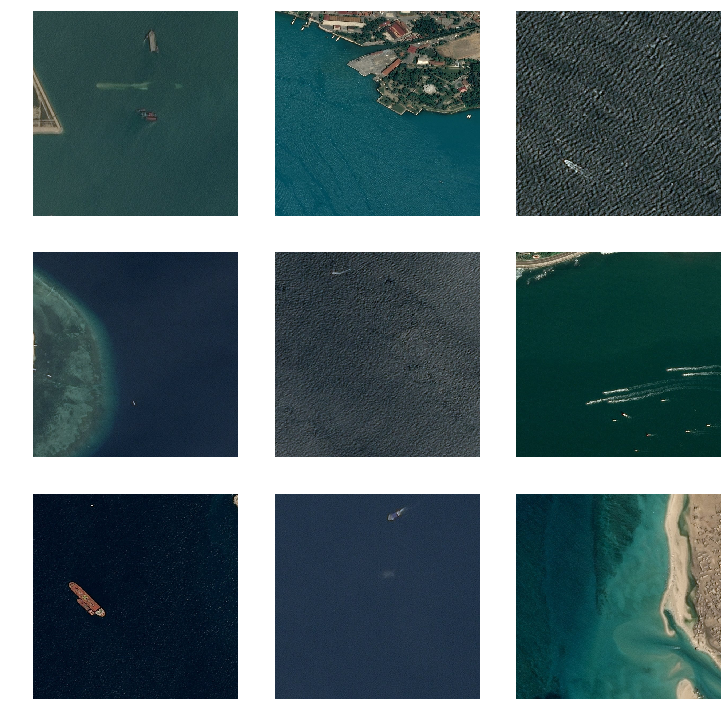

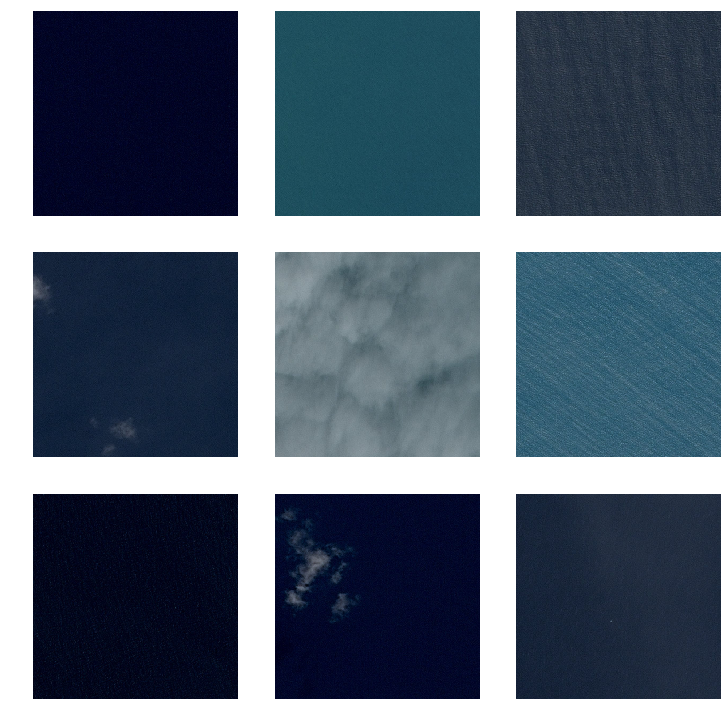

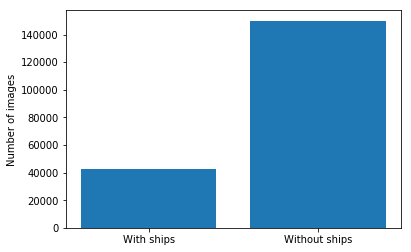

Number of images with ships : 42556 | Number of images without ships : 149999  (x3.5)


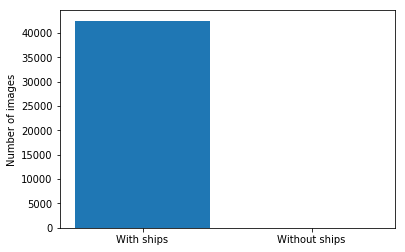

Number of images with ships : 42556 | Number of images without ships : 0  (x0.0)


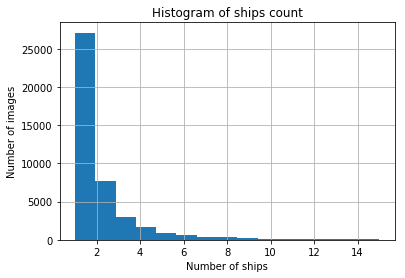

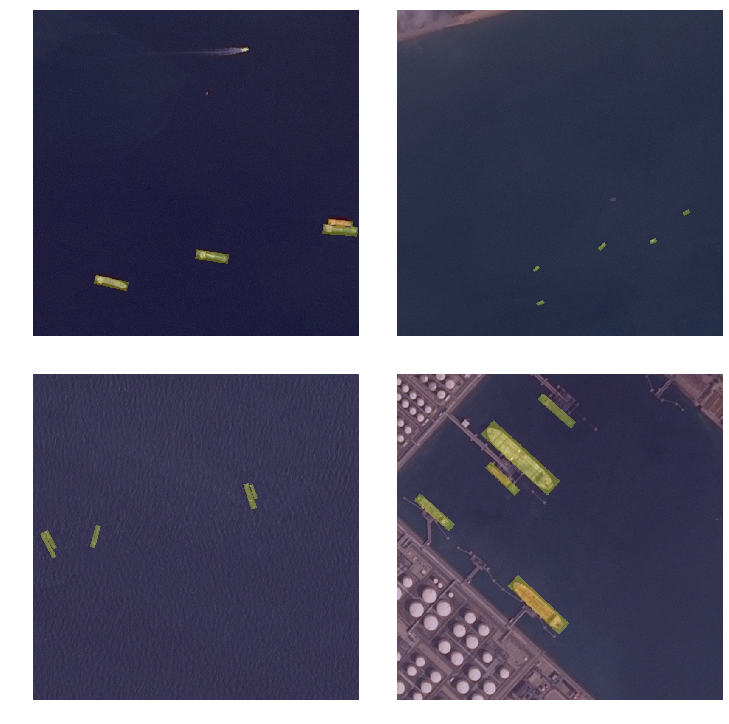

Number of training images : 40428


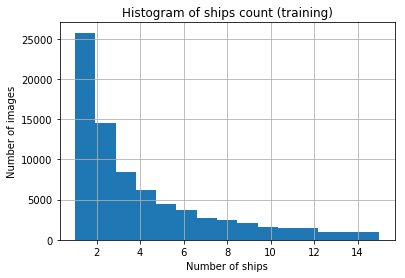

Number of validation images : 2128


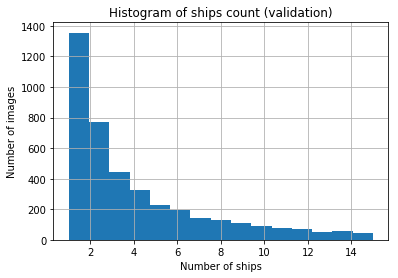

In [5]:
# Read CSV as dataframe
masks = pd.read_csv(os.path.join(data_root, 'train_ship_segmentations_v2.csv'))
print('Total number of images (original): %d' % masks['ImageId'].value_counts().shape[0])
if SHOW_PIXELS_DIST == True:
    show_pixels_distribution(masks)
    show_pixels_distribution(masks.dropna())

# Create a dataframe with unique images id as indexes and number of ships and image sizes as new columns
masks = masks[~masks['ImageId'].isin(['6384c3e78.jpg'])] # remove corrupted file
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
print('Total number of images (after removing corrupted images): %d' % masks['ImageId'].value_counts().shape[0])

# Plot some images with ships
img_wships = masks[~masks['EncodedPixels'].isna()].sample(9)
fig, arr = plt.subplots(3,3, figsize=(10,10), constrained_layout=True)
for i, img in enumerate(img_wships['ImageId']):
    r = int(i / 3)
    c = i % 3
    arr[r,c].imshow(imread(os.path.join(path_train, img)))
    arr[r,c].axis('off')
plt.show()

# Plot some images without ships
img_woships = masks[masks['EncodedPixels'].isna()].sample(9)
fig, arr = plt.subplots(3,3, figsize=(10,10), constrained_layout=True)
for i, img in enumerate(img_woships['ImageId']):
    r = int(i / 3)
    c = i % 3
    arr[r,c].imshow(imread(os.path.join(path_train, img)))
    arr[r,c].axis('off')
plt.show()

# Count number of ships per image
df_wships = masks.dropna()
df_wships = df_wships.groupby('ImageId').size().reset_index(name='counts')
df_woships = masks[masks['EncodedPixels'].isna()]

# Make a plot
plt.bar(['With ships','Without ships'], [len(df_wships), len(df_woships)])
plt.ylabel('Number of images')
plt.show()

print('Number of images with ships : %d | Number of images without ships : %d  (x%0.1f)' \
      % (df_wships.shape[0], df_woships.shape[0], df_woships.shape[0] / df_wships.shape[0]))
## -> Unbalanced dataset

# Remove images without ships to help getting a more balanced dataset
masks = masks.dropna()
df_woships = masks[masks['EncodedPixels'].isna()]

# Make a plot
plt.bar(['With ships','Without ships'], [len(df_wships), len(df_woships)])
plt.ylabel('Number of images')
plt.show()

print('Number of images with ships : %d | Number of images without ships : %d  (x%0.1f)' \
      % (df_wships.shape[0], df_woships.shape[0], df_woships.shape[0] / df_wships.shape[0]))
## -> Balanced dataset

# Plot histogram
hist = df_wships.hist(bins=df_wships['counts'].max())
plt.title("Histogram of ships count")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show(hist)

# Plot images with 15 ships
df_w15ships = df_wships.loc[df_wships['counts'] == 5]
list_w15ships = df_w15ships.values.tolist()

fig, axarr = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
for i in range(4):
    rd_id = random.randrange(len(list_w15ships))
    img_masks = masks.loc[masks['ImageId'] == str(list_w15ships[rd_id][0]), 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
        all_masks += rle_decode(mask)
        
    r = int(i / 2)
    c = i % 2

    axarr[r][c].imshow(imread(os.path.join(path_train, list_w15ships[rd_id][0])))
    axarr[r][c].imshow(all_masks, alpha=0.3)
    axarr[r][c].axis('off')
                    
plt.show()

# Split dataset into training and validation sets
# statritify : same histograms of numbe of ships
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')

train_ids, val_ids = train_test_split(unique_img_ids, test_size=0.05, stratify=unique_img_ids['counts'], random_state=42)
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, val_ids)

train_df['counts'] = train_df.apply(lambda c_row: c_row['counts'] if isinstance(c_row['EncodedPixels'], str) else 0, 1)
valid_df['counts'] = valid_df.apply(lambda c_row: c_row['counts'] if isinstance(c_row['EncodedPixels'], str) else 0, 1)

print('Number of training images : %d' % train_df['ImageId'].value_counts().shape[0])
train_df['counts'].hist(bins=train_df['counts'].max())
plt.title("Histogram of ships count (training)")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show()

print('Number of validation images : %d' % valid_df['ImageId'].value_counts().shape[0])
valid_df['counts'].hist(bins=valid_df['counts'].max())
plt.title("Histogram of ships count (validation)")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show()

*[Optional] : convert segmentation masks into bouding boxes (without rotation) and compute ship sizes (diagonals) -> takes time*

In [6]:
if SHOW_SHIP_DIAG == True:
# Transform masks to bounding boxes
# Analisys of ship sizes through the dataset

    bboxes = []
    bboxes_dict = {}

    # Compute bouding boxes coordinates
    for img_id in tqdm(df_wships['ImageId']):
        bboxes = []

        # Get binary mask
        masks_val = masks.loc[masks['ImageId'] == str(img_id), 'EncodedPixels'].tolist()

        # Take the individual ship masks and create a single mask array for all ships
        bin_mask = np.zeros((768, 768))
        for mask in masks_val:
            bin_mask += rle_decode(mask)

        # Extract bounding boxes
        lbl = label(bin_mask)
        props = regionprops(lbl)

        for prop in props:
            bboxes.append(prop.bbox)

        bboxes_dict[img_id] = bboxes.copy()
    
    # Plot some images with bouding boxes
    fig, axarr = plt.subplots(2, 2, figsize = (15, 15), constrained_layout=True)
    for i in range(4):
        img_id = df_wships.loc[i*4, 'ImageId']
        img = imread(os.path.join(path_train, str(img_id)))

        bboxs = bboxes_dict[img_id]
        for bbox in bboxs:
            cv2.rectangle(img, (bbox[1], bbox[0]), (bbox[3], bbox[2]), (255, 0, 0), 2)

        r = int(i / 2)
        c = i % 2
        axarr[r][c].imshow(img)
        axarr[r][c].axis('off')

    plt.show()

    # Compute diagonal of each ships and plot histogram
    diag = []
    for i in bboxes_dict:
        for j in bboxes_dict[i]:
            diag.append(int(np.sqrt((j[0] - j[2]) ** 2 + (j[1] - j[3]) ** 2)))

    df_diag = pd.DataFrame(diag, columns =['Diagonal size'])

    axes = df_diag.hist()
    plt.title("Histogram of ship diagonal sizes")
    plt.xlabel("Number of ships")
    plt.ylabel("Diagonal in pixels")

**PART 2 - DATASET, LOSSES, METRICS **

Dataset

In [7]:
class AirbusDataset(Dataset):
    def __init__(self, in_df, transform=None, mode='train'):
        grp = list(in_df.groupby('ImageId'))
        self.image_ids =  [_id for _id, _ in grp] 
        self.image_masks = [m['EncodedPixels'].values for _,m in grp]
        self.transform = transform
        self.mode = mode
        self.img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  # use mean and std from ImageNet 

    def __len__(self):
        return len(self.image_ids)
               
    def __getitem__(self, idx):
        img_file_name = self.image_ids[idx]
        if (self.mode == 'train') | (self.mode == 'validation'):
            rgb_path = os.path.join(path_train, img_file_name)
        else:
            rgb_path = os.path.join(path_test, img_file_name)
        img = imread(rgb_path)
        mask = masks_as_image(self.image_masks[idx])
        
        if self.transform is not None: 
            img, mask = self.transform(img, mask)
            
        if (self.mode == 'train') | (self.mode == 'validation'):
            return self.img_transform(img), torch.from_numpy(np.moveaxis(mask, -1, 0)).float()  
        else:
            return self.img_transform(img), str(img_file_name)

Data augmentation

In [8]:
# Implementation from  https://github.com/ternaus/robot-surgery-segmentation
def clip(img, dtype, maxval):
    return np.clip(img, 0, maxval).astype(dtype)

class DualCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x, mask=None):
        for t in self.transforms:
            x, mask = t(x, mask)
        return x, mask

class ImageOnly:
    def __init__(self, trans):
        self.trans = trans

    def __call__(self, x, mask=None):
        return self.trans(x), mask


class VerticalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            img = cv2.flip(img, 0)
            if mask is not None:
                mask = cv2.flip(mask, 0)
        return img, mask


class HorizontalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            img = cv2.flip(img, 1)
            if mask is not None:
                mask = cv2.flip(mask, 1)
        return img, mask


class RandomFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            d = random.randint(-1, 1)
            img = cv2.flip(img, d)
            if mask is not None:
                mask = cv2.flip(mask, d)
        return img, mask


class Rotate:
    def __init__(self, limit=90, prob=0.5):
        self.prob = prob
        self.limit = limit

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            angle = random.uniform(-self.limit, self.limit)

            height, width = img.shape[0:2]
            mat = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1.0)
            img = cv2.warpAffine(img, mat, (height, width),
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_REFLECT_101)
            if mask is not None:
                mask = cv2.warpAffine(mask, mat, (height, width),
                                      flags=cv2.INTER_LINEAR,
                                      borderMode=cv2.BORDER_REFLECT_101)

        return img, mask

class RandomCrop:
    def __init__(self, size):
        self.h = size[0]
        self.w = size[1]

    def __call__(self, img, mask=None):
        height, width, _ = img.shape

        h_start = np.random.randint(0, height - self.h)
        w_start = np.random.randint(0, width - self.w)

        img = img[h_start: h_start + self.h, w_start: w_start + self.w,:]

        assert img.shape[0] == self.h
        assert img.shape[1] == self.w

        if mask is not None:
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=2)
            mask = mask[h_start: h_start + self.h, w_start: w_start + self.w,:]

        return img, mask

class CenterCrop:
    def __init__(self, size):
        self.height = size[0]
        self.width = size[1]

    def __call__(self, img, mask=None):
        h, w, c = img.shape
        dy = (h - self.height) // 2
        dx = (w - self.width) // 2
        y1 = dy
        y2 = y1 + self.height
        x1 = dx
        x2 = x1 + self.width
        img = img[y1:y2, x1:x2,:]
        if mask is not None:
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=2)
            mask = mask[y1:y2, x1:x2,:]

        return img, mask

Metrics

In [9]:
def compute_metrics(pred, true, batch_size=16, threshold=0.5):
    pred = pred.view(batch_size, -1)
    true = true.view(batch_size, -1)
    
    pred = (pred > threshold).float()
    true = (true > threshold).float()
    
    pred_sum = pred.sum(-1)
    true_sum = true.sum(-1)
    
    neg_index = torch.nonzero(true_sum == 0)
    pos_index = torch.nonzero(true_sum >= 1)
    
    dice_neg = (pred_sum == 0).float()
    dice_pos = 2 * ((pred * true).sum(-1)) / ((pred + true).sum(-1))
    
    dice_neg = dice_neg[neg_index]
    dice_pos = dice_pos[pos_index]
    
    dice = torch.cat([dice_pos, dice_neg])
    jaccard = dice / (2 - dice)
    
    return dice, jaccard
    
class metrics:
    def __init__(self, batch_size=16, threshold=0.5):
        self.threshold = threshold
        self.batchsize = batch_size
        self.dice = []
        self.jaccard = []
    def collect(self, pred, true):
        pred = torch.sigmoid(pred)
        dice, jaccard = compute_metrics(pred, true, batch_size=self.batchsize, threshold=self.threshold)
        self.dice.extend(dice)
        self.jaccard.extend(jaccard)
    def get(self):
        dice = np.nanmean(self.dice)
        jaccard = np.nanmean(self.jaccard)
        return dice, jaccard

Losses

In [10]:
class BCEJaccardWithLogitsLoss(nn.Module):
    def __init__(self, jaccard_weight=1, smooth=1):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight
        self.smooth = smooth

    def forward(self, outputs, targets):
        if outputs.size() != targets.size():
            raise ValueError("size mismatch, {} != {}".format(outputs.size(), targets.size()))
            
        loss = self.bce(outputs, targets)

        if self.jaccard_weight:
            targets = (targets == 1.0).float()
            targets = targets.view(-1)
            outputs = torch.sigmoid(outputs)
            outputs = outputs.view(-1)

            intersection = (targets * outputs).sum()
            union = outputs.sum() + targets.sum() - intersection

            loss -= self.jaccard_weight * torch.log((intersection + self.smooth ) / (union + self.smooth )) # try with 1-dice
        return loss

class BCEDiceWithLogitsLoss(nn.Module):
    def __init__(self, dice_weight=1, smooth=1):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight
        self.smooth = smooth
        
    def __call__(self, outputs, targets):
        if outputs.size() != targets.size():
            raise ValueError("size mismatch, {} != {}".format(outputs.size(), targets.size()))
            
        loss = self.bce(outputs, targets)

        targets = (targets == 1.0).float()
        targets = targets.view(-1)
        outputs = F.sigmoid(outputs)
        outputs = outputs.view(-1)

        intersection = (outputs * targets).sum()
        dice = 2.0 * (intersection + self.smooth)  / (targets.sum() + outputs.sum() + self.smooth)
        
        loss -= self.dice_weight * torch.log(dice) # try with 1- dice

        return loss
    
class FocalWithLogitsLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.alpha = alpha
        self.gamma = gamma
        
    def __call__(self, outputs, targets):
        if outputs.size() != targets.size():
            raise ValueError("size mismatch, {} != {}".format(outputs.size(), targets.size()))
            
        loss = self.bce(outputs, targets)

        targets = (targets == 1.0).float()
        targets = targets.view(-1)
        outputs = torch.sigmoid(outputs)
        outputs = outputs.view(-1)
        outputs = torch.where(targets == 1, outputs, 1 - outputs)

        focal = self.alpha * (1 - outputs) ** (self.gamma)
        loss *= focal.mean()

        return loss

def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

Models

In [11]:
"""Improved U-Net""" 
# Implementation from https://github.com/timctho/unet-pytorch/
class IUNet_down_block(torch.nn.Module):
    def __init__(self, input_channel, output_channel, down_size):
        super(IUNet_down_block, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.max_pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.down_size = down_size

    def forward(self, x):
        if self.down_size:
            x = self.max_pool(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x

class IUNet_up_block(torch.nn.Module):
    def __init__(self, prev_channel, input_channel, output_channel):
        super(IUNet_up_block, self).__init__()
        self.up_sampling = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv1 = torch.nn.Conv2d(prev_channel + input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.relu = torch.nn.ReLU()

    def forward(self, prev_feature_map, x):
        x = self.up_sampling(x)
        x = torch.cat((x, prev_feature_map), dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x


class IUNet(torch.nn.Module):
    def __init__(self):
        super(IUNet, self).__init__()

        self.down_block1 = IUNet_down_block(3, 16, False)
        self.down_block2 = IUNet_down_block(16, 32, True)
        self.down_block3 = IUNet_down_block(32, 64, True)
        self.down_block4 = IUNet_down_block(64, 128, True)
        self.down_block5 = IUNet_down_block(128, 256, True)
        self.down_block6 = IUNet_down_block(256, 512, True)
        self.down_block7 = IUNet_down_block(512, 1024, True)

        self.mid_conv1 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(1024)
        self.mid_conv2 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(1024)
        self.mid_conv3 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(1024)

        self.up_block1 = IUNet_up_block(512, 1024, 512)
        self.up_block2 = IUNet_up_block(256, 512, 256)
        self.up_block3 = IUNet_up_block(128, 256, 128)
        self.up_block4 = IUNet_up_block(64, 128, 64)
        self.up_block5 = IUNet_up_block(32, 64, 32)
        self.up_block6 = IUNet_up_block(16, 32, 16)

        self.last_conv1 = torch.nn.Conv2d(16, 16, 3, padding=1)
        self.last_bn = torch.nn.BatchNorm2d(16)
        self.last_conv2 = torch.nn.Conv2d(16, 1, 1, padding=0)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        self.x1 = self.down_block1(x)
        self.x2 = self.down_block2(self.x1)
        self.x3 = self.down_block3(self.x2)
        self.x4 = self.down_block4(self.x3)
        self.x5 = self.down_block5(self.x4)
        self.x6 = self.down_block6(self.x5)
        self.x7 = self.down_block7(self.x6)
        self.x7 = self.relu(self.bn1(self.mid_conv1(self.x7)))
        self.x7 = self.relu(self.bn2(self.mid_conv2(self.x7)))
        self.x7 = self.relu(self.bn3(self.mid_conv3(self.x7)))
        x = self.up_block1(self.x6, self.x7)
        x = self.up_block2(self.x5, x)
        x = self.up_block3(self.x4, x)
        x = self.up_block4(self.x3, x)
        x = self.up_block5(self.x2, x)
        x = self.up_block6(self.x1, x)
        x = self.relu(self.last_bn(self.last_conv1(x)))
        x = self.last_conv2(x)
        return x
        
        
"""Original U-Net"""
class UNet_down_block(torch.nn.Module):
    def __init__(self, input_channel, output_channel, down_size):
        super(UNet_down_block, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.max_pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.down_size = down_size

    def forward(self, x):
        if self.down_size:
            x = self.max_pool(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class UNet_up_block(torch.nn.Module):
    def __init__(self, prev_channel, input_channel, output_channel):
        super(UNet_up_block, self).__init__()
        self.up_sampling = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv1 = torch.nn.Conv2d(prev_channel + input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.relu = torch.nn.ReLU()

    def forward(self, prev_feature_map, x):
        x = self.up_sampling(x)
        x = torch.cat((x, prev_feature_map), dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x


class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down_block1 = UNet_down_block(3, 64, False)
        self.down_block2 = UNet_down_block(64, 128, True)
        self.down_block3 = UNet_down_block(128, 256, True)
        self.down_block4 = UNet_down_block(256, 512, True)
        self.down_block5 = UNet_down_block(512, 1024, True)

        self.up_block1 = UNet_up_block(512, 1024, 512)
        self.up_block2 = UNet_up_block(256, 512, 256)
        self.up_block3 = UNet_up_block(128, 256, 128)
        self.up_block4 = UNet_up_block(64, 128, 64)

        self.last_conv = torch.nn.Conv2d(64, 1, 1, padding=0)

    def forward(self, x):
        self.x1 = self.down_block1(x)
        self.x2 = self.down_block2(self.x1)
        self.x3 = self.down_block3(self.x2)
        self.x4 = self.down_block4(self.x3)
        self.x5 = self.down_block5(self.x4)
        x = self.up_block1(self.x4, self.x5)
        x = self.up_block2(self.x3, x)
        x = self.up_block3(self.x2, x)
        x = self.up_block4(self.x1, x)
        x = self.last_conv(x)
        return x

# PART 3 - CREATE TRAIN AND VALIDATION LOOPS

In [12]:
# main train routine
# Implementation from  https://github.com/ternaus/robot-surgery-segmentation
def train(lr, model, criterion, train_loader, valid_loader, init_optimizer, train_batch_sz=16, valid_batch_sz=4, n_epochs=1, fold=1):
    
    model_path = Path('model_{fold}.pt'.format(fold=fold))
    if model_path.exists():
        state = torch.load(str(model_path))
        epoch = state['epoch']
        step = state['step']
        model.load_state_dict(state['model'])
        print('Restored model, epoch {}, step {:,}'.format(epoch, step))
    else:
        epoch = 1
        step = 0

    save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

    report_each = 50
    log = open('train_{fold}.log'.format(fold=fold),'at', encoding='utf8')
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = init_optimizer(lr)

    for epoch in range(epoch, n_epochs + 1):
        model.train()
        random.seed()
        tq = tqdm(total=len(train_loader) *  train_batch_sz)
        tq.set_description('Epoch {}, lr {}'.format(epoch, lr))
        losses = []
        valid_metrics = metrics(batch_size=valid_batch_sz)  # for validation
        tl = train_loader
        try:
            mean_loss = 0
            for i, (inputs, targets) in enumerate(tl):
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model.forward(inputs)
                loss = criterion(outputs, targets)
                batch_size = inputs.size(0)
                loss.backward()
                optimizer.step()
                step += 1
                tq.update(batch_size)
                losses.append(loss.item())
                mean_loss = np.mean(losses[-report_each:])
                tq.set_postfix(loss='{:.5f}'.format(mean_loss))
                if i and i % report_each == 0:
                    write_event(log, step, loss=mean_loss)
            write_event(log, step, loss=mean_loss)
            tq.close()
            save(epoch + 1)
            
            # Validation
            comb_loss_metrics = validation(model, criterion, valid_loader, valid_metrics)
            write_event(log, step, **comb_loss_metrics)

        except KeyboardInterrupt:
            tq.close()
            print('Ctrl+C, saving snapshot')
            save(epoch)
            print('done.')
            return
        
def validation(model: nn.Module, criterion, valid_loader, metrics):
    print("Validation")
    
    losses = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    for inputs, targets in valid_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model.forward(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        metrics.collect(outputs.detach().cpu(), targets.detach().cpu()) # get metrics 
    
    valid_loss = np.mean(losses)  # float
    valid_dice, valid_jaccard = metrics.get() # float

    print('Valid loss: {:.5f}, Jaccard: {:.5f}, Dice: {:.5f}'.format(valid_loss, valid_jaccard, valid_dice))
    comb_loss_metrics = {'valid_loss': valid_loss, 'jaccard': valid_jaccard.item(), 'dice': valid_dice.item()}
    
    return comb_loss_metrics

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()

# PART 4 - TRAINING

Train samples : 40428 | Validation samples : 2128


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Epoch 1, lr 0.0001: 100%|█████████▉| 40428/40432 [24:35<00:00, 27.40it/s, loss=0.01632]


Validation


Epoch 2, lr 0.0001:   0%|          | 0/40432 [00:00<?, ?it/s]

Valid loss: 0.01212, Jaccard: 0.54560, Dice: 0.59568


Epoch 2, lr 0.0001: 100%|█████████▉| 40428/40432 [16:27<00:00, 40.93it/s, loss=0.00940]


Validation


Epoch 3, lr 0.0001:   0%|          | 0/40432 [00:00<?, ?it/s]

Valid loss: 0.00620, Jaccard: 0.61043, Dice: 0.65791


Epoch 3, lr 0.0001: 100%|█████████▉| 40428/40432 [16:18<00:00, 41.32it/s, loss=0.00614]


Validation
Valid loss: 0.00552, Jaccard: 0.61872, Dice: 0.67267


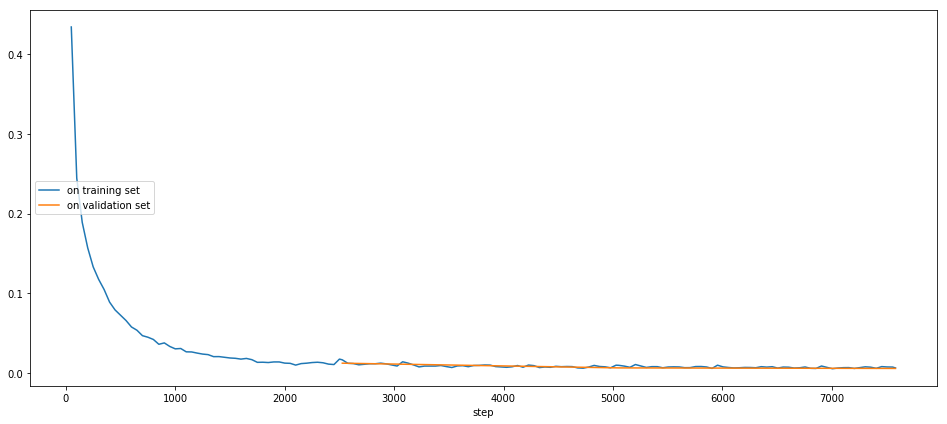

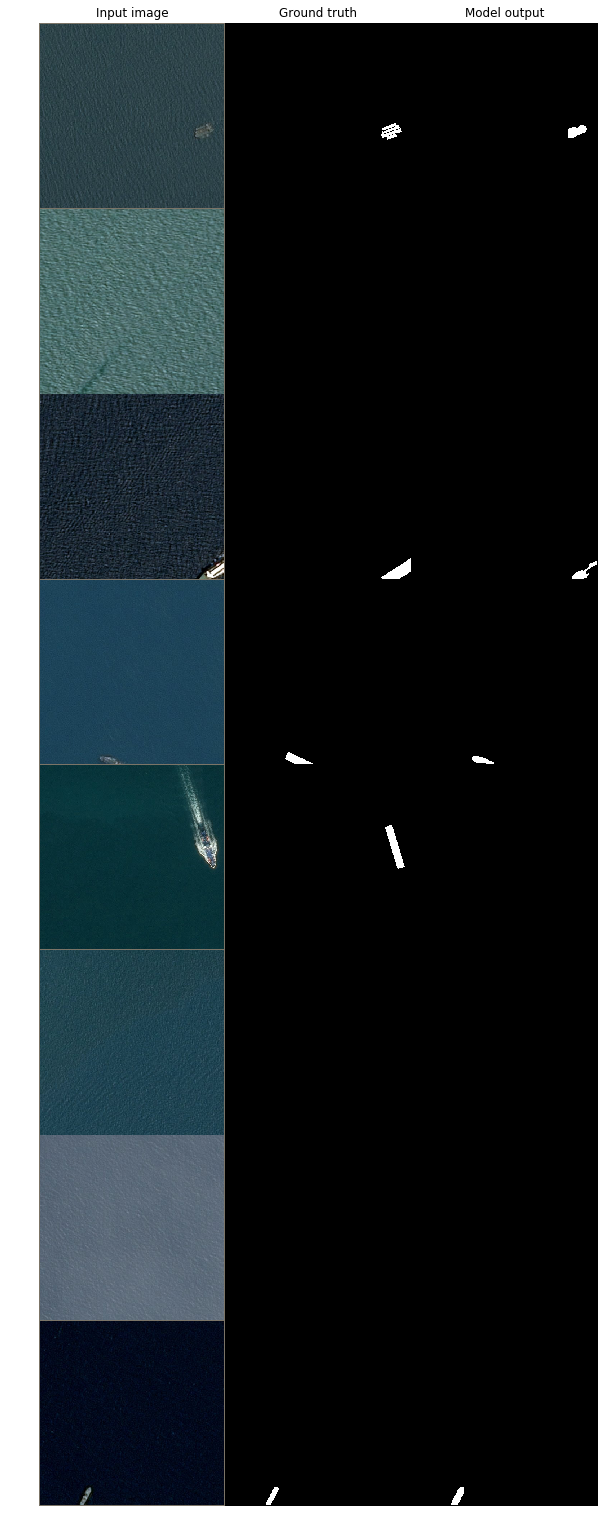

In [13]:
# Data augmentation
train_transform = DualCompose([HorizontalFlip(), VerticalFlip(), RandomCrop((256,256,3))])
val_transform = DualCompose([CenterCrop((512,512,3))])

# Initialize dataset
train_dataset = AirbusDataset(train_df, transform=train_transform, mode='train')
val_dataset = AirbusDataset(valid_df, transform=val_transform, mode='validation')

print('Train samples : %d | Validation samples : %d' % (len(train_dataset), len(val_dataset)))

# Get loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SZ_TRAIN, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SZ_VALID, shuffle=True, num_workers=0)

if SHOW_IMG_LOADER == True:
    # Display some images from loader
    images, mask = next(iter(train_loader))
    imshow_mask(torchvision.utils.make_grid(images, nrow=1), torchvision.utils.make_grid(mask, nrow=1))
    plt.show()
    
# Train
run_id = 1

if MODEL_SEG == 'IUNET':
    model = IUNet()
elif MODEL_SEG == 'UNET':
    model = UNet()
elif MODEL_SEG == 'UNET_RESNET34ImgNet':
    model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)
    if FREEZE_RESNET == True:
        for name, p in model.named_parameters():
            if "encoder" in name:
                p.requires_grad = False
else:
    raise NameError("model not supported")
    
if LOSS == 'BCEWithDigits':
    criterion = nn.BCEWithLogitsLoss()
elif LOSS == 'FocalLossWithDigits':
    criterion = MixedLoss(10, 2)
elif LOSS == 'BCEDiceWithLogitsLoss':
    criterion = BCEDiceWithLogitsLoss()
elif LOSS == 'BCEJaccardWithLogitsLoss':
    criterion = BCEJaccardWithLogitsLoss()
else:
    raise NameError("loss not supported")

train(init_optimizer=lambda lr: optim.Adam(model.parameters(), lr=lr),
        lr = LR,
        n_epochs = N_EPOCHS,
        model=model,
        criterion=criterion,
        train_loader=train_loader,
        valid_loader=val_loader,
        train_batch_sz= BATCH_SZ_TRAIN,
        valid_batch_sz=BATCH_SZ_VALID,
        fold=run_id
        )


# Plot losses
log_file = 'train_{fold}.log'.format(fold=run_id)
logs = pd.read_json(log_file, lines=True)

plt.figure(figsize=(26,6))
plt.subplot(1, 2, 1)
plt.plot(logs.step[logs.loss.notnull()],
            logs.loss[logs.loss.notnull()],
            label="on training set")

plt.plot(logs.step[logs.valid_loss.notnull()],
            logs.valid_loss[logs.valid_loss.notnull()],
            label = "on validation set")
         
plt.xlabel('step')
plt.legend(loc='center left')
plt.tight_layout()
plt.show();


# Model inference
model_path ='model_{fold}.pt'.format(fold=run_id)
state = torch.load(str(model_path))
state = {key.replace('module.', ''): value for key, value in state['model'].items()}
model.load_state_dict(state)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

val_dataset = AirbusDataset(valid_df, transform=val_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)

# Display some images from loader
images, gt = next(iter(val_loader))
gt = gt.data.cpu()
images = images.to(device)
out = model.forward(images)
out = ((out > 0).float()) * 255
images = images.data.cpu()
out = out.data.cpu()
imshow_gt_out(torchvision.utils.make_grid(images, nrow=1),torchvision.utils.make_grid(gt, nrow=1), torchvision.utils.make_grid(out, nrow=1))
plt.show()

# PART 5 - SUBMISSION

In [14]:
from skimage.morphology import binary_opening, disk
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def multi_rle_encode(img):
    labels = label(img)
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

list_img_test = os.listdir(path_test)
print(len(list_img_test), 'test images found')

# Create dataframe
test_df = pd.DataFrame({'ImageId': list_img_test, 'EncodedPixels': None})
loader = torch.utils.data.DataLoader(dataset=AirbusDataset(test_df, transform=None, mode='test'), shuffle=False, batch_size=2, num_workers=0)
    
out_pred_rows = []
for batch_num, (inputs, paths) in enumerate(tqdm(loader, desc='Test')):
    inputs = inputs.to(device)
    outputs = model(inputs)
    for i, image_name in enumerate(paths):
        mask = F.sigmoid(outputs[i,0]).data.detach().cpu().numpy()
        cur_seg = binary_opening(mask>0.5, disk(2))
        cur_rles = multi_rle_encode(cur_seg)
        if len(cur_rles)>0:
            for c_rle in cur_rles:
                out_pred_rows += [{'ImageId': image_name, 'EncodedPixels': c_rle}]
        else:
            out_pred_rows += [{'ImageId': image_name, 'EncodedPixels': None}]
        
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
submission_df.sample(10)

15606 test images found


Test: 100%|██████████| 7803/7803 [18:08<00:00,  7.17it/s]


,ImageId,EncodedPixels
12592,bd8405c05.jpg,None
11168,a81a6efa4.jpg,None
11117,a7659e121.jpg,51934 1 52701 3 53468 5 54236 5 55005 3 55774 1
11828,b1d8ae69f.jpg,None
10463,9dc3b5d21.jpg,None
12941,c324a8631.jpg,None
2628,27e4f1009.jpg,None
3785,38eb986ac.jpg,None
10808,a2916a60a.jpg,None
8188,7bd9cafea.jpg,None
